In [119]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
import scipy
import scipy as sp
from scipy.optimize import fsolve
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv
from scipy.optimize import fsolve

In [224]:
alpha = 0.5; Bo=0.1; Ca=0.1; Re=1; Ma=0.25; epsilon=0.1

In [225]:
def w_0(x):
    r = ((1-alpha)*x+1+alpha)/2
    return 1/4*(2*np.log(r/alpha) - (r**2 - alpha**2))
def w_0_prime(x): 
    r = ((1-alpha)*x+1+alpha)/2
    return 1/2*(1/r - r)
def w_0_prime_prime(x):
    r = ((1-alpha)*x+1+alpha)/2
    return -1/2*(1/r**2 + 1)
w_0 = np.vectorize(w_0)
w_0_prime = np.vectorize(w_0_prime)
w_0_prime_prime = np.vectorize(w_0_prime_prime)

In [245]:
N =  10
x = np.flip(cheb.chebgauss(N+1)[0])
x_eval = np.linspace(-1,1,1000)
x_interior = x[2:(N-1)]
print(len(x_interior))
print(len(x))
matrix = np.zeros((N+1, N+1))
#build the polys at the points
cheb_poly = np.zeros((N+1, N+1))
cheb_der = np.zeros_like(cheb_poly)
cheb_der_der = np.zeros_like(cheb_poly)
cheb_der3 = np.zeros_like(cheb_poly)
cheb_der4 = np.zeros_like(cheb_poly)
# row is the order, column is the evaluation point
cheb_poly[0,:] = 1
cheb_poly[1,:] = x
cheb_der[1,:] = 1
for k in range(2,N+1):
    cheb_poly[k,:] = 2*x*cheb_poly[k-1,:] - cheb_poly[k-2,:]
    cheb_der[k,:] = 2*cheb_poly[k-1] + 2*x*cheb_der[k-1, :] - cheb_der[k-2, :]
    cheb_der_der[k,:] = 4*cheb_der[k-1] + 2*x*cheb_der_der[k-1, :] - cheb_der_der[k-2, :]
    cheb_der3[k,:] = 6*cheb_der_der[k-1] + 2*x*cheb_der3[k-1, :] - cheb_der3[k-2, :]
    cheb_der4[k,:] = 8*cheb_der3[k-1] + 2*x*cheb_der4[k-1, :] - cheb_der4[k-2, :]

7
11


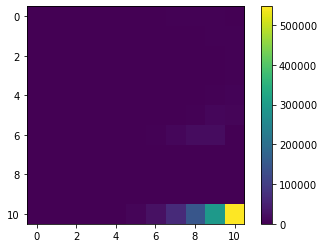

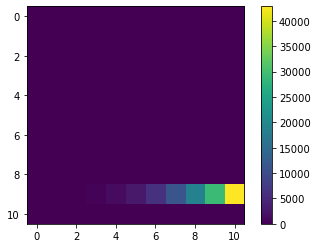

Eigen function


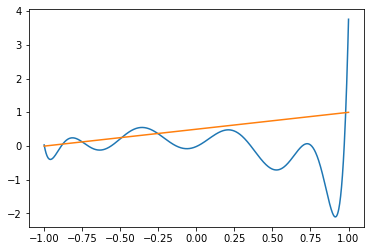

(-3.253936158108041e+26-2.2527613034941802e+24j)
(2.1901614819441417e-05-0.0031425499048887166j)
818695.2551600938
920331007480622.8
(34.45575451200227+0.043821547143720885j)
10.0

(-3.2665169544069675e+26-2.6287117626350017e+25j)
(0.0030418884977638848-0.0375525038775003j)
79978.68296268719
572229952821919.1
(33.98056204194472+2.74973067523222j)
20.0

(-3.3004547106128154e+26-4.6524935690968115e+25j)
(0.01009932677575481-0.07119576048622857j)
54997.80121407975
1361945197706791.8
(34.84769036519618-3.089650989959901j)
30.0

(-3.355932709324429e+26-5.944442047622967e+25j)
(0.018442618362229365-0.10351765487421088j)
48477.69488713976
2597844133107856.5
(35.493458316404684-2.820917125298286j)
40.0

(-3.4332517514206045e+26-6.144482447674928e+25j)
(0.024135276320067203-0.13418231730542787j)
45982.64578464476
1035332765053243.9
(34.57349928208281-2.6406232808096024j)
50.0

(-3.532833498050474e+26-4.880762916787042e+25j)
(0.0226153081246675-0.16307273355406474j)
44814.164324434874
4850301671

In [246]:
# I want all the equations to be more or less the same size
kappa_vect = np.linspace(0.01, 1, 10)
Lambda_vect0 = np.zeros_like(kappa_vect, dtype=np.complex128)
Lambda_vect1 = np.zeros_like(kappa_vect)
psi_0 = np.zeros((len(kappa_vect), len(x_eval)), dtype=np.complex128)
r_interior = ((1-alpha)*x_interior + (1 + alpha))/2 #(half)
r = ((1-alpha)*x + (1 + alpha))/2 
factor = 2/(1-alpha)
for index, k in enumerate(kappa_vect):
    #first we compute Lambda0
    matrix_interior_LHS = np.zeros((N-3,N+1), dtype=np.complex128)
    matrix_interior_RHS = np.zeros((N-3,N+1), dtype=np.complex128)
    # stokes operator
    #print(np.shape(matrix_interior_LHS))
    matrix_interior_LHS += np.transpose(k**4*r_interior**3*cheb_poly[:,2:(N-1)])
    matrix_interior_LHS += np.transpose(r_interior**3*cheb_der4[:,2:(N-1)]*factor**4)
    matrix_interior_LHS += np.transpose(-2*r_interior**2*cheb_der3[:,2:(N-1)]*factor**3)
    matrix_interior_LHS += np.transpose((3*r_interior - 2*k**2*r_interior**3)*cheb_der_der[:, 2:(N-1)]*factor**2)
    matrix_interior_LHS += np.transpose((2*k**2*r_interior**2 - 3)*cheb_der[:,2:(N-1)]*factor)
    
    
    
    matrix_interior_LHS = matrix_interior_LHS/factor**4
    matrix_interior_RHS = matrix_interior_RHS/factor**4
    
    no_slip_u = np.transpose(cheb_poly[:,0]).reshape(1,-1)
    no_slip_w = np.transpose(cheb_der[:,0]*factor).reshape(1,-1)
    S = factor*cheb_der[:,-1] - factor**2*cheb_der_der[:,-1] - k**2*cheb_poly[:,-1] #tangential stress
    kinematic_LHS = np.transpose(1j*k*cheb_poly[:,-1] - 1j*k*w_0(1)*S).reshape(1,-1)
    kinematic_RHS = np.transpose(S).reshape(1,-1)
    
    p_terms = 1/k*(1j*cheb_der3[:,-1]*factor**3 - 1j*cheb_der_der[:, -1]*factor**2 + (w_0(1)*Re*k+1j-1j*k**2)*cheb_der[:,-1]*factor)
    normal_stress_LHS = np.transpose(Bo*p_terms-2*Ca*1j*k*(cheb_der[:,-1]*factor-cheb_poly[:,-1])+(1-2*Ma)*S-k**2*S).reshape(1,-1)
    normal_stress_LHS = normal_stress_LHS/factor**3
    
    normal_stress_RHS = np.transpose(Bo/k*1j*Re*cheb_der[:,-1]*factor).reshape(1,-1)
    normal_stress_RHS = normal_stress_RHS/factor**3
    matrix_LHS = np.concatenate([matrix_interior_LHS, no_slip_u, no_slip_w, kinematic_LHS, normal_stress_LHS],
                               axis = 0)
    matrix_RHS = np.concatenate([matrix_interior_RHS, np.zeros_like(no_slip_u), 
                                np.zeros_like(no_slip_w),kinematic_RHS, normal_stress_RHS], axis=0)
    evals = scipy.linalg.eigvals(matrix_LHS,matrix_RHS)
    #print(evals)
    Lambda_vect0[index] = evals[np.argmin(abs(evals[~np.isinf(evals.real)]))]
    
    eigen_function = scipy.linalg.eig(matrix_LHS,matrix_RHS)[-1][np.argmin(abs(evals[~np.isinf(evals.real)]))]
    eigens = cheb.chebval(x_eval, eigen_function)
    psi_0[index,:] = eigens/(eigens[-1].imag)
    if index % 10 ==0:
        plt.imshow(abs(matrix_LHS))
        plt.colorbar();plt.show()
        #plt.imshow(abs(matrix_interior_LHS))
        #plt.colorbar();plt.show()
        plt.imshow(abs(matrix_RHS))
        plt.colorbar();plt.show()
        print('Eigen function')
        #print(scipy.linalg.eig(matrix_LHS,matrix_RHS)[-1][np.argmin(abs(evals[~np.isinf(evals)]))])
        plt.plot(x_eval,psi_0[index,:].real, label ='real')
        plt.plot(x_eval,psi_0[index,:].imag);plt.show()
    
    # now we have Lambda0, and psi0
    # we need to solve the system 
    print(np.linalg.det(matrix_LHS))
    s = Lambda_vect0[index]
    print(Lambda_vect0[index])
    print(np.linalg.norm(matrix_LHS @ eigen_function - s * matrix_RHS @ eigen_function))
    M = matrix_LHS - Lambda_vect0[index]*matrix_RHS
    U, S, V = np.linalg.svd(M)
    det_A = np.prod(S) * np.linalg.det(U) * np.linalg.det(V)
    print(np.prod(S))
    log_det_A = np.sum(np.log(S)) + np.log(np.linalg.det(U)) + np.log(np.linalg.det(V))
    print(log_det_A)
    print((index+1)/len(kappa_vect)*100)
    print()

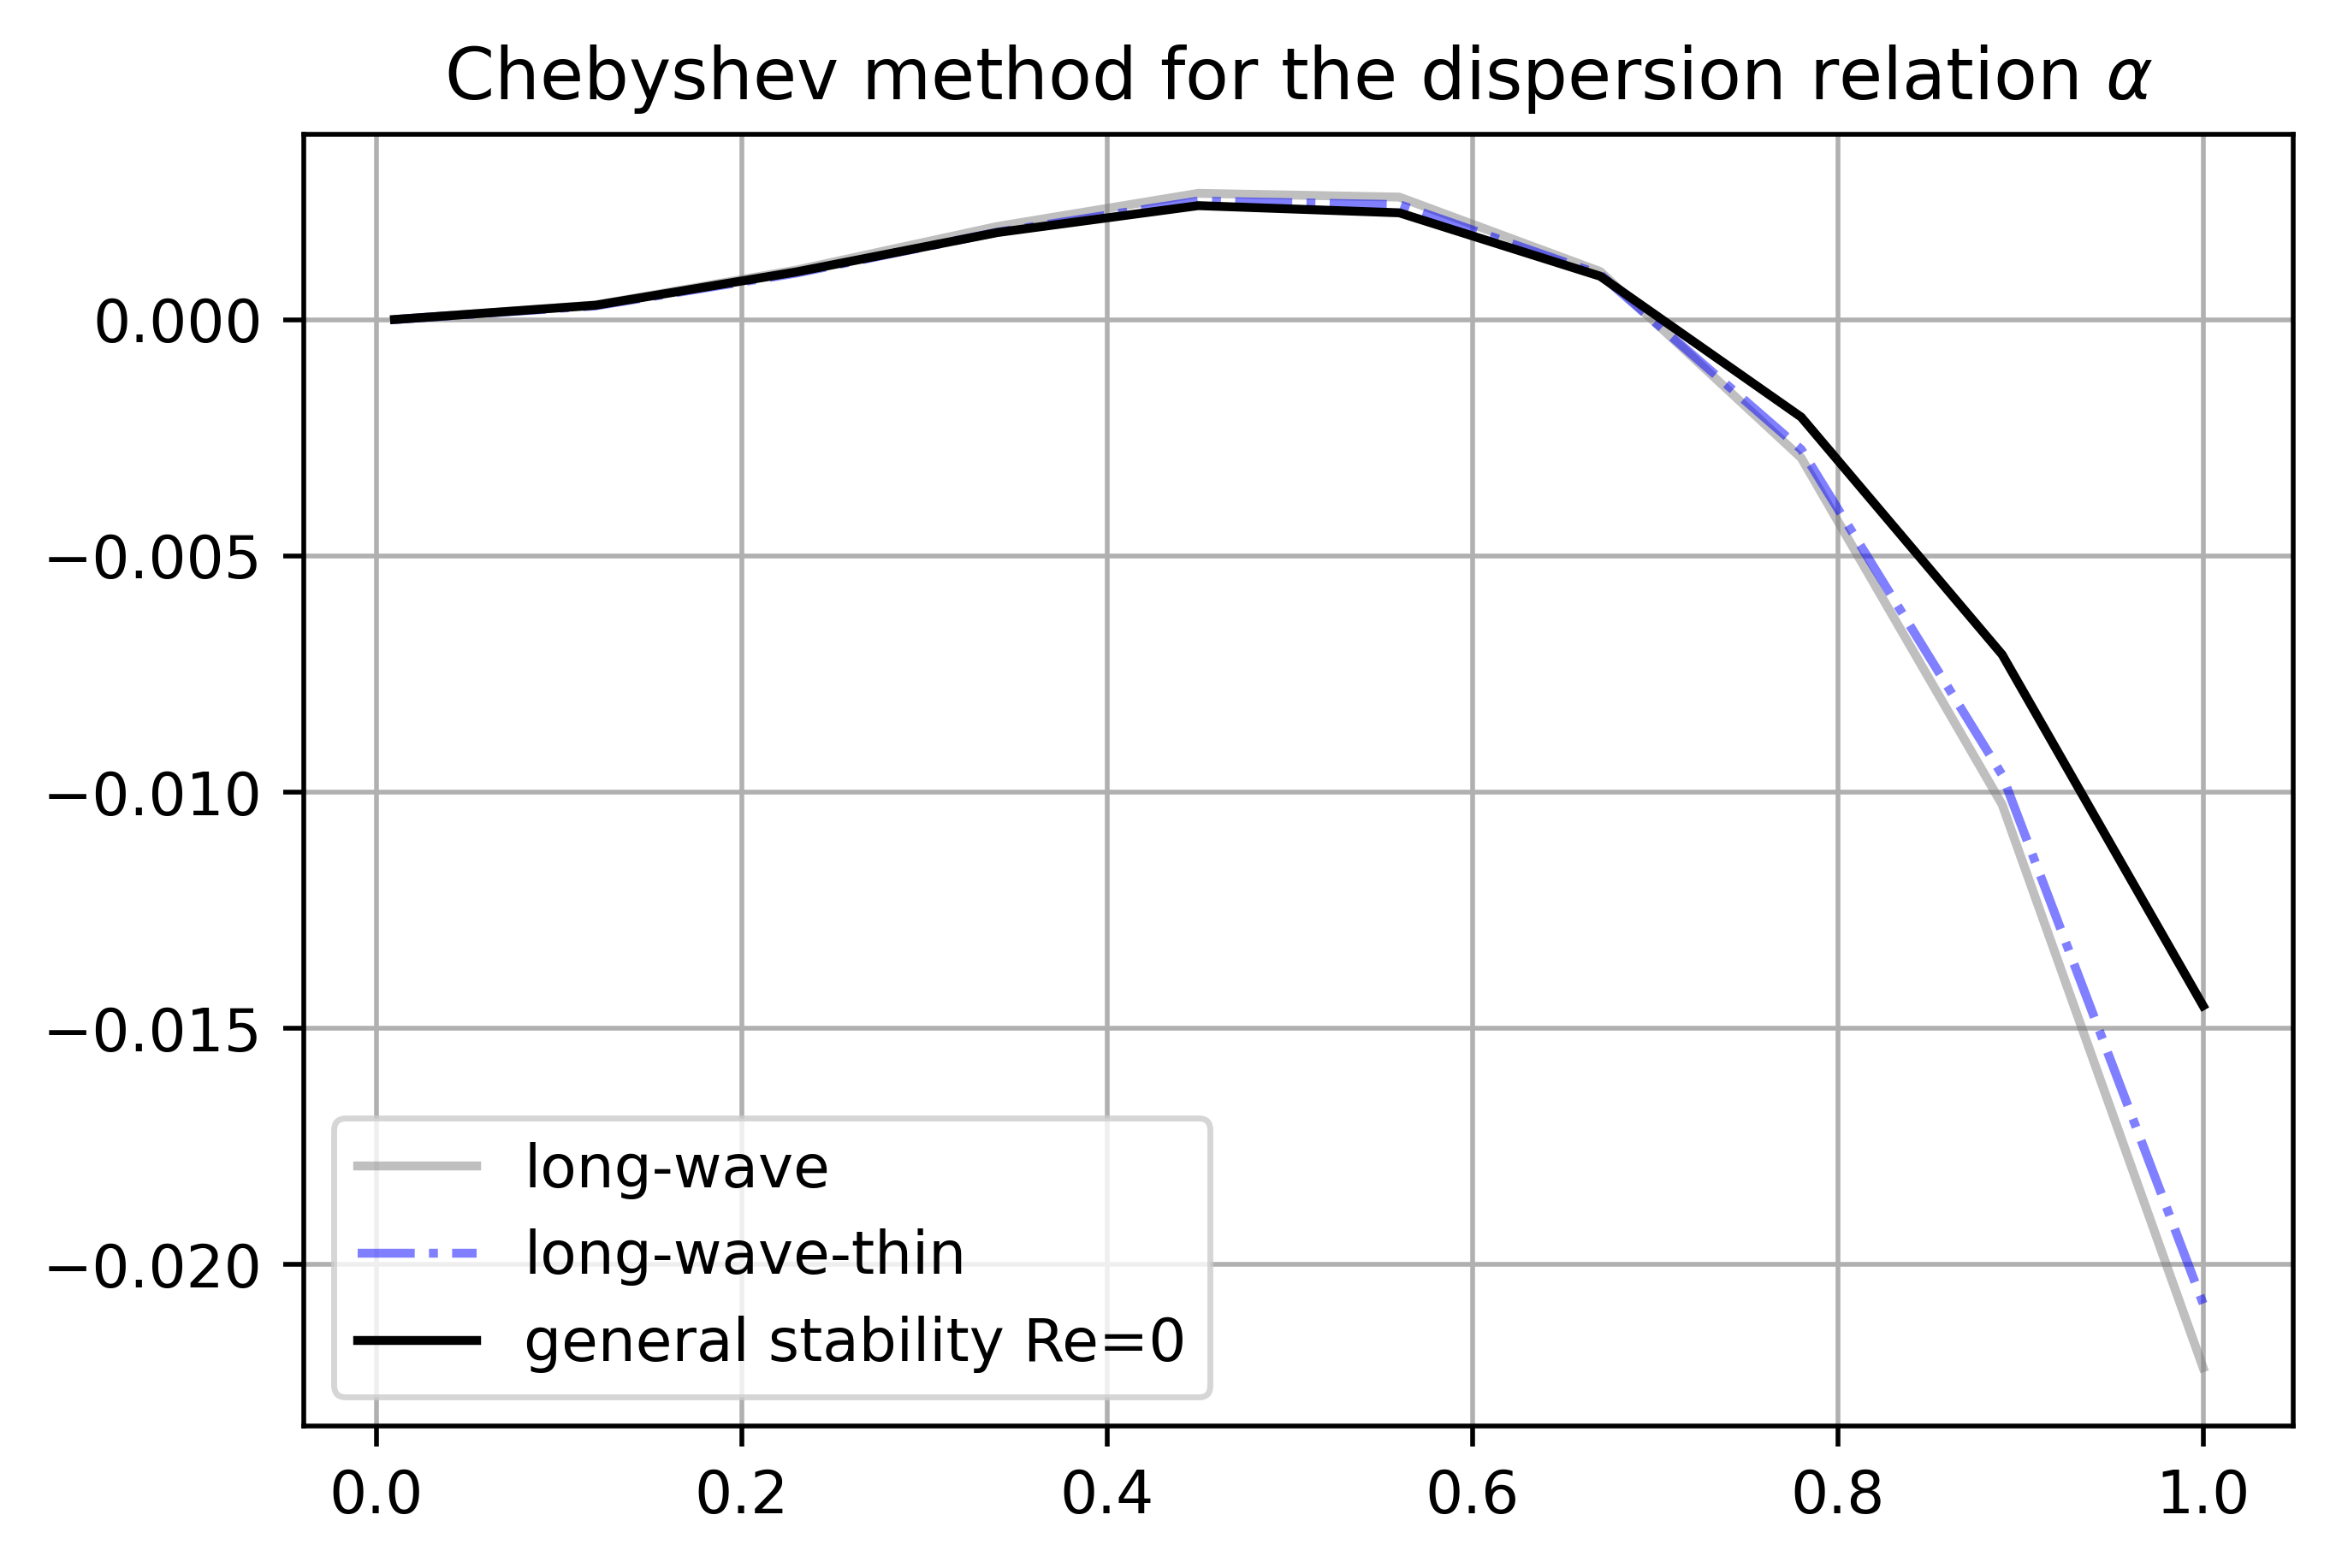

In [247]:
k_vect = kappa_vect/epsilon
D = 1-2*Ma
lambda_vect_thin = k_vect**2/3*(D - epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))
plt.figure(dpi=500)
plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='grey', alpha=0.5)
plt.plot(k_vect*epsilon, epsilon**2*lambda_vect_thin, '-.' , label='long-wave-thin', color='blue', alpha=0.5)
#plt.plot(kappa_vect, )
plt.plot(kappa_vect, epsilon*Lambda_vect0.real, label ='general stability Re=0',color='black')
plt.legend()
plt.grid()
plt.title(r'Chebyshev method for the dispersion relation $\alpha$')
#plt.savefig(f'proof_of_working_method_chebyshev_alpha_{alpha}_with_Re_1.jpg')
plt.show()

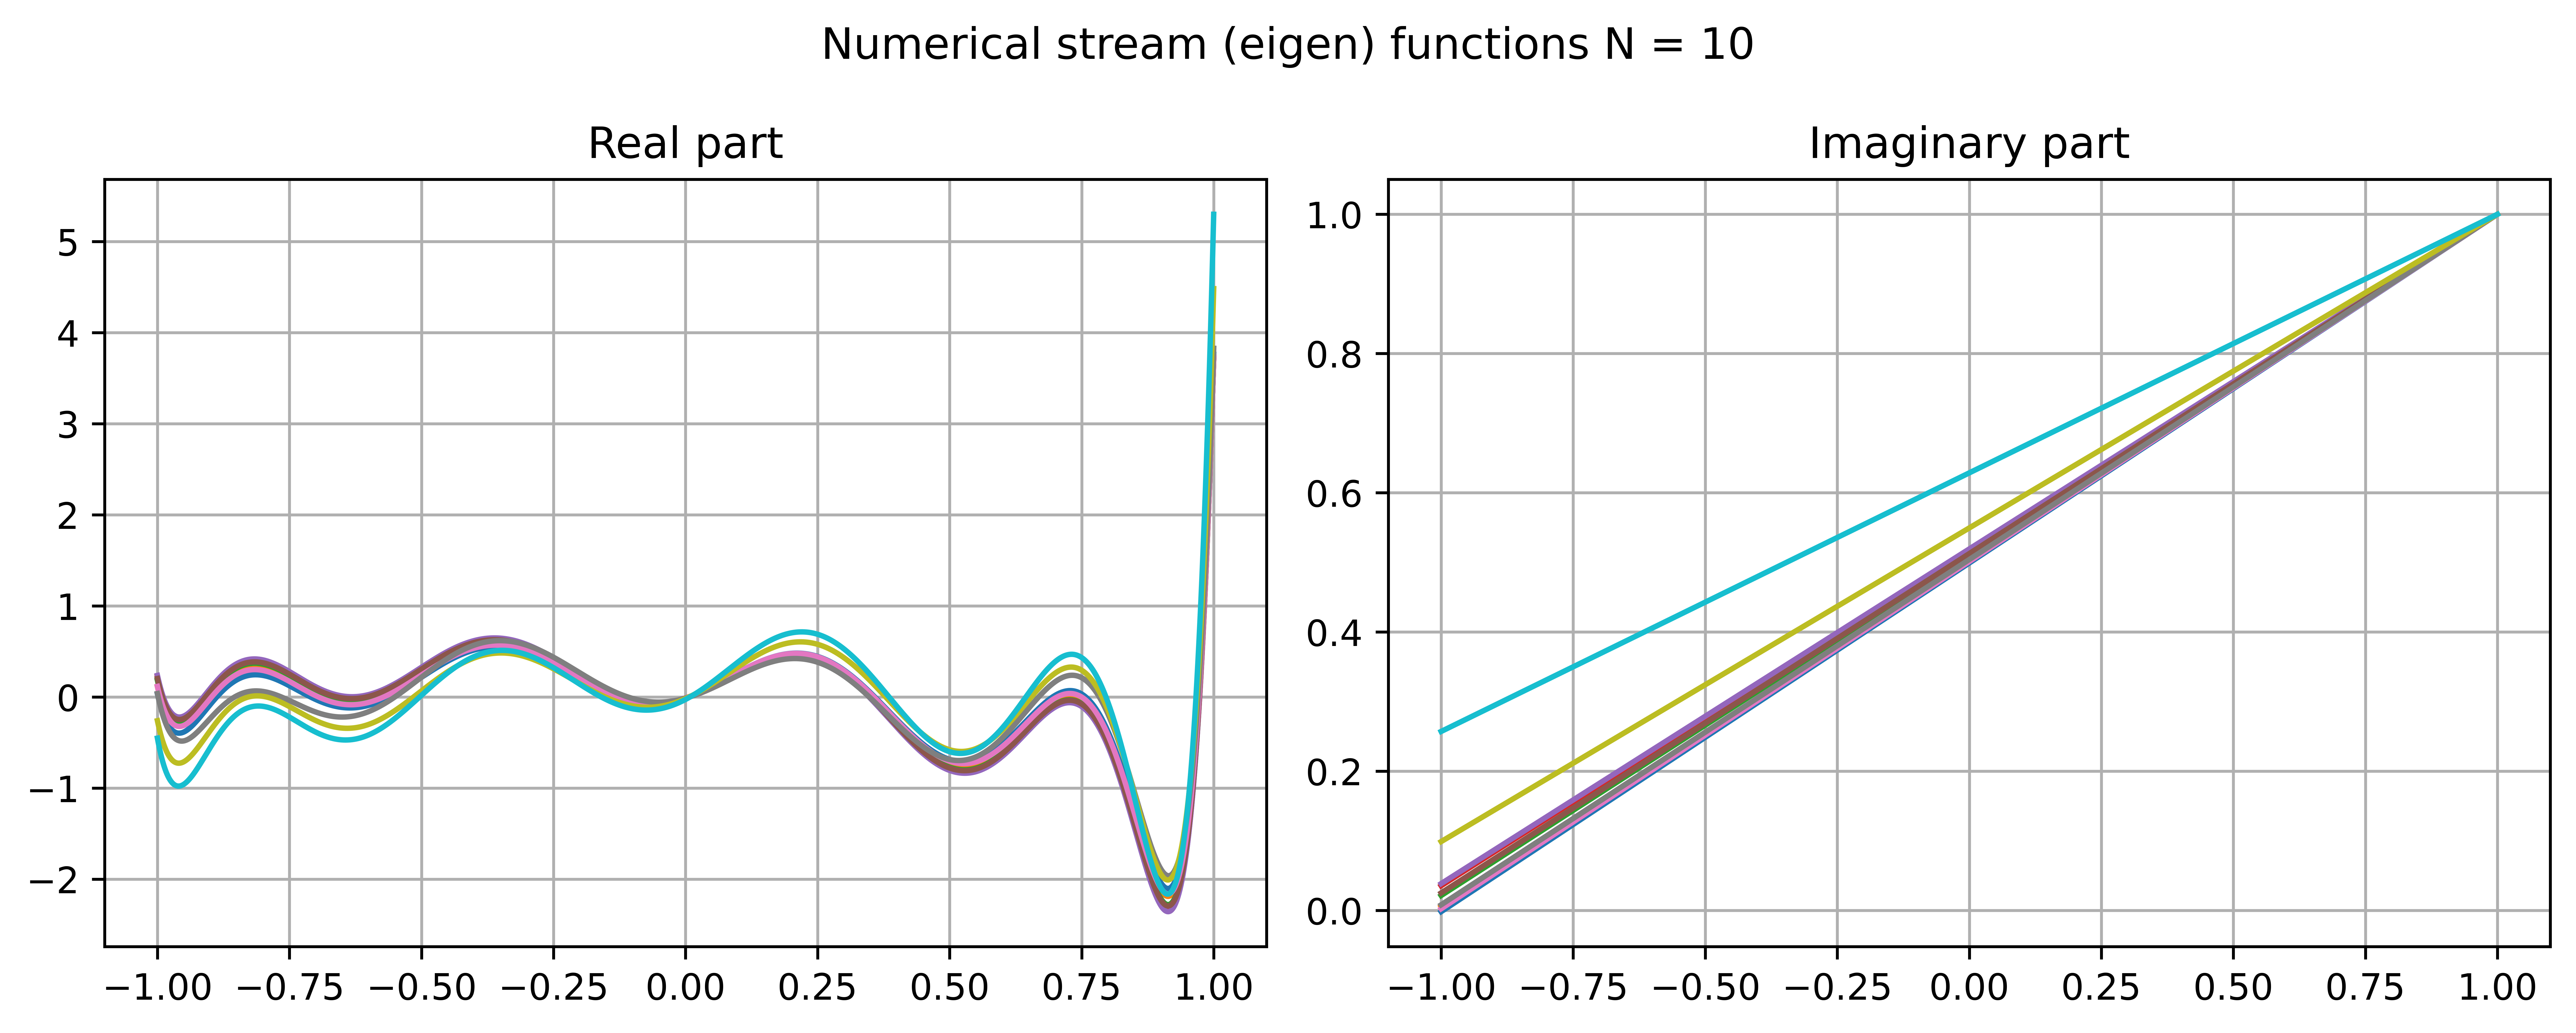

In [248]:
fig, ax =plt.subplots(dpi=1000, nrows=1, ncols =2, figsize=(10,4));
colors = plt.cm.rainbow(np.linspace(0, 1, len(kappa_vect)))
ax[0].plot(x_eval, psi_0.real.T)
ax[0].grid(True)
ax[0].set_title('Real part')
ax[1].plot(x_eval, psi_0.imag.T)
ax[1].set_title('Imaginary part')
ax[1].grid(True)
fig.suptitle(f'Numerical stream (eigen) functions N = {N}')
plt.tight_layout()
plt.savefig(f'figures/numerical_eigen_N_{N}.pdf')
plt.show()
#plt.figure(dpi=700);plt.plot(np.abs(psi_0).T)
#plt.show()

In [249]:
Lambda_vect0

array([ 2.19016148e-05-0.00314255j,  3.04188850e-03-0.0375525j ,
        1.00993268e-02-0.07119576j,  1.84426184e-02-0.10351765j,
        2.41352763e-02-0.13418232j,  2.26153081e-02-0.16307273j,
        9.18680968e-03-0.1902407j , -2.06347602e-02-0.2158411j ,
       -7.09271131e-02-0.24007467j, -1.45279340e-01-0.26314853j])

In [196]:
## now we loop around the values of kappa

epsilon = 0.1
kappa_vect = np.linspace(0.01,1, 50)
Lambda_vect_anal = np.zeros_like(kappa_vect, dtype='complex')
eigenfunction_coefs = np.zeros((len(kappa_vect), 4), dtype='complex')
eigenfunction_coefs[:,-1] = 1
alpha_ = 0.5; Bo = epsilon; Ca = epsilon; D_ = 0.5
r_ = np.linspace(alpha_, 1, 50)
import sympy as sp
from sympy.functions.special.bessel import besseli, besselk, besselj, bessely
from scipy.special import jv,kv,iv,yv
kappa, r, alpha,Lambda, D = sp.symbols('kappa, r, alpha,Lambda,D')
bessel = {'besselj': jv,'besselk':kv,'besseli':iv,'bessely':yv}
libraries = [bessel, "numpy"] 
v = sp.Matrix([sp.I *r/kappa**2*besseli(1, kappa*r)-sp.I*r**2*besseli(0,kappa*r)/2/kappa, 
                       -sp.I*r*besseli(1,kappa*r)/kappa, 
                       -sp.I*r*besselk(1,kappa*r)/kappa**2-sp.I*r**2*besselk(0,kappa*r)/2/kappa,
                       sp.I*r*besselk(1, kappa*r)/kappa
                      ])#*kappa**2/sp.I/r*2

v = sp.simplify(v)
u = 1/r*v*sp.I*kappa; w = -1/r*v.diff(r)
w_0 = 1/4*(sp.log(r/alpha_)-(r**2-alpha_**2))

expr_p = sp.Matrix([besseli(0,kappa*r), 0, besselk(0, kappa*r), 0])
colors = plt.cm.rainbow(np.linspace(0, 1, len(kappa_vect)))
#kinematic_bc
expr_S = sp.simplify(sp.I*kappa*u+w.diff(r))
expr_kinematic = sp.simplify((Lambda+w_0.subs(r,1)*sp.I*kappa)*expr_S-u)
expr_normal = sp.simplify(Bo*expr_p - 2*Ca*u.diff(r) + (D-kappa**2)*expr_S)
bessel = {'besselj': jv,'besselk':kv,'besseli':iv,'bessely':yv}
libraries = [bessel, "numpy"] 
#fig,ax = plt.subplots(dpi=1200, nrows=1, ncols = 2,figsize=(10,4))
for j,kappa_ in enumerate(kappa_vect):
    def build_matrix(Lambda_):

        matrix_sp = np.zeros((4,4), dtype = 'complex')
        matrix_sp[0,:] = sp.lambdify([kappa, Lambda], v.subs(r,alpha_), modules=libraries)(kappa_, Lambda_).T
        matrix_sp[1,:] = sp.lambdify([kappa, Lambda], 
                                     v.diff(r).subs(r,alpha_), modules=libraries)(kappa_, Lambda_).T


        matrix_sp[2,:] = sp.lambdify([kappa, Lambda], expr_kinematic.subs(r,1), 
                                  modules=libraries)(kappa_, Lambda_).T
        matrix_sp[3,:] = sp.lambdify([kappa,Lambda, D], expr_normal.subs(r,1), 
                                  modules=libraries)(kappa_, Lambda_, D_).T
        return matrix_sp
    
    def f(Lambda_):
        return np.linalg.det(build_matrix(Lambda_))
    Lambda_vect_anal[j] = scipy.optimize.root_scalar(f, x0=.1,x1=1,method='secant').root
    #compute eigenfunction
    matrix = build_matrix(Lambda_vect_anal[j])
    A = matrix[0:-1, 0:-1]
    b = -matrix[0:-1, -1]
    eigenfunction_coefs[j,0:-1] = np.linalg.solve(A, b)
    print((j+1)/len(kappa_vect)*100)



2.0
4.0
6.0
8.0
10.0
12.0
14.000000000000002
16.0
18.0
20.0
22.0
24.0
26.0
28.000000000000004
30.0
32.0
34.0
36.0
38.0
40.0
42.0
44.0
46.0
48.0
50.0
52.0
54.0
56.00000000000001
57.99999999999999
60.0
62.0
64.0
66.0
68.0
70.0
72.0
74.0
76.0
78.0
80.0
82.0
84.0
86.0
88.0
90.0
92.0
94.0
96.0
98.0
100.0


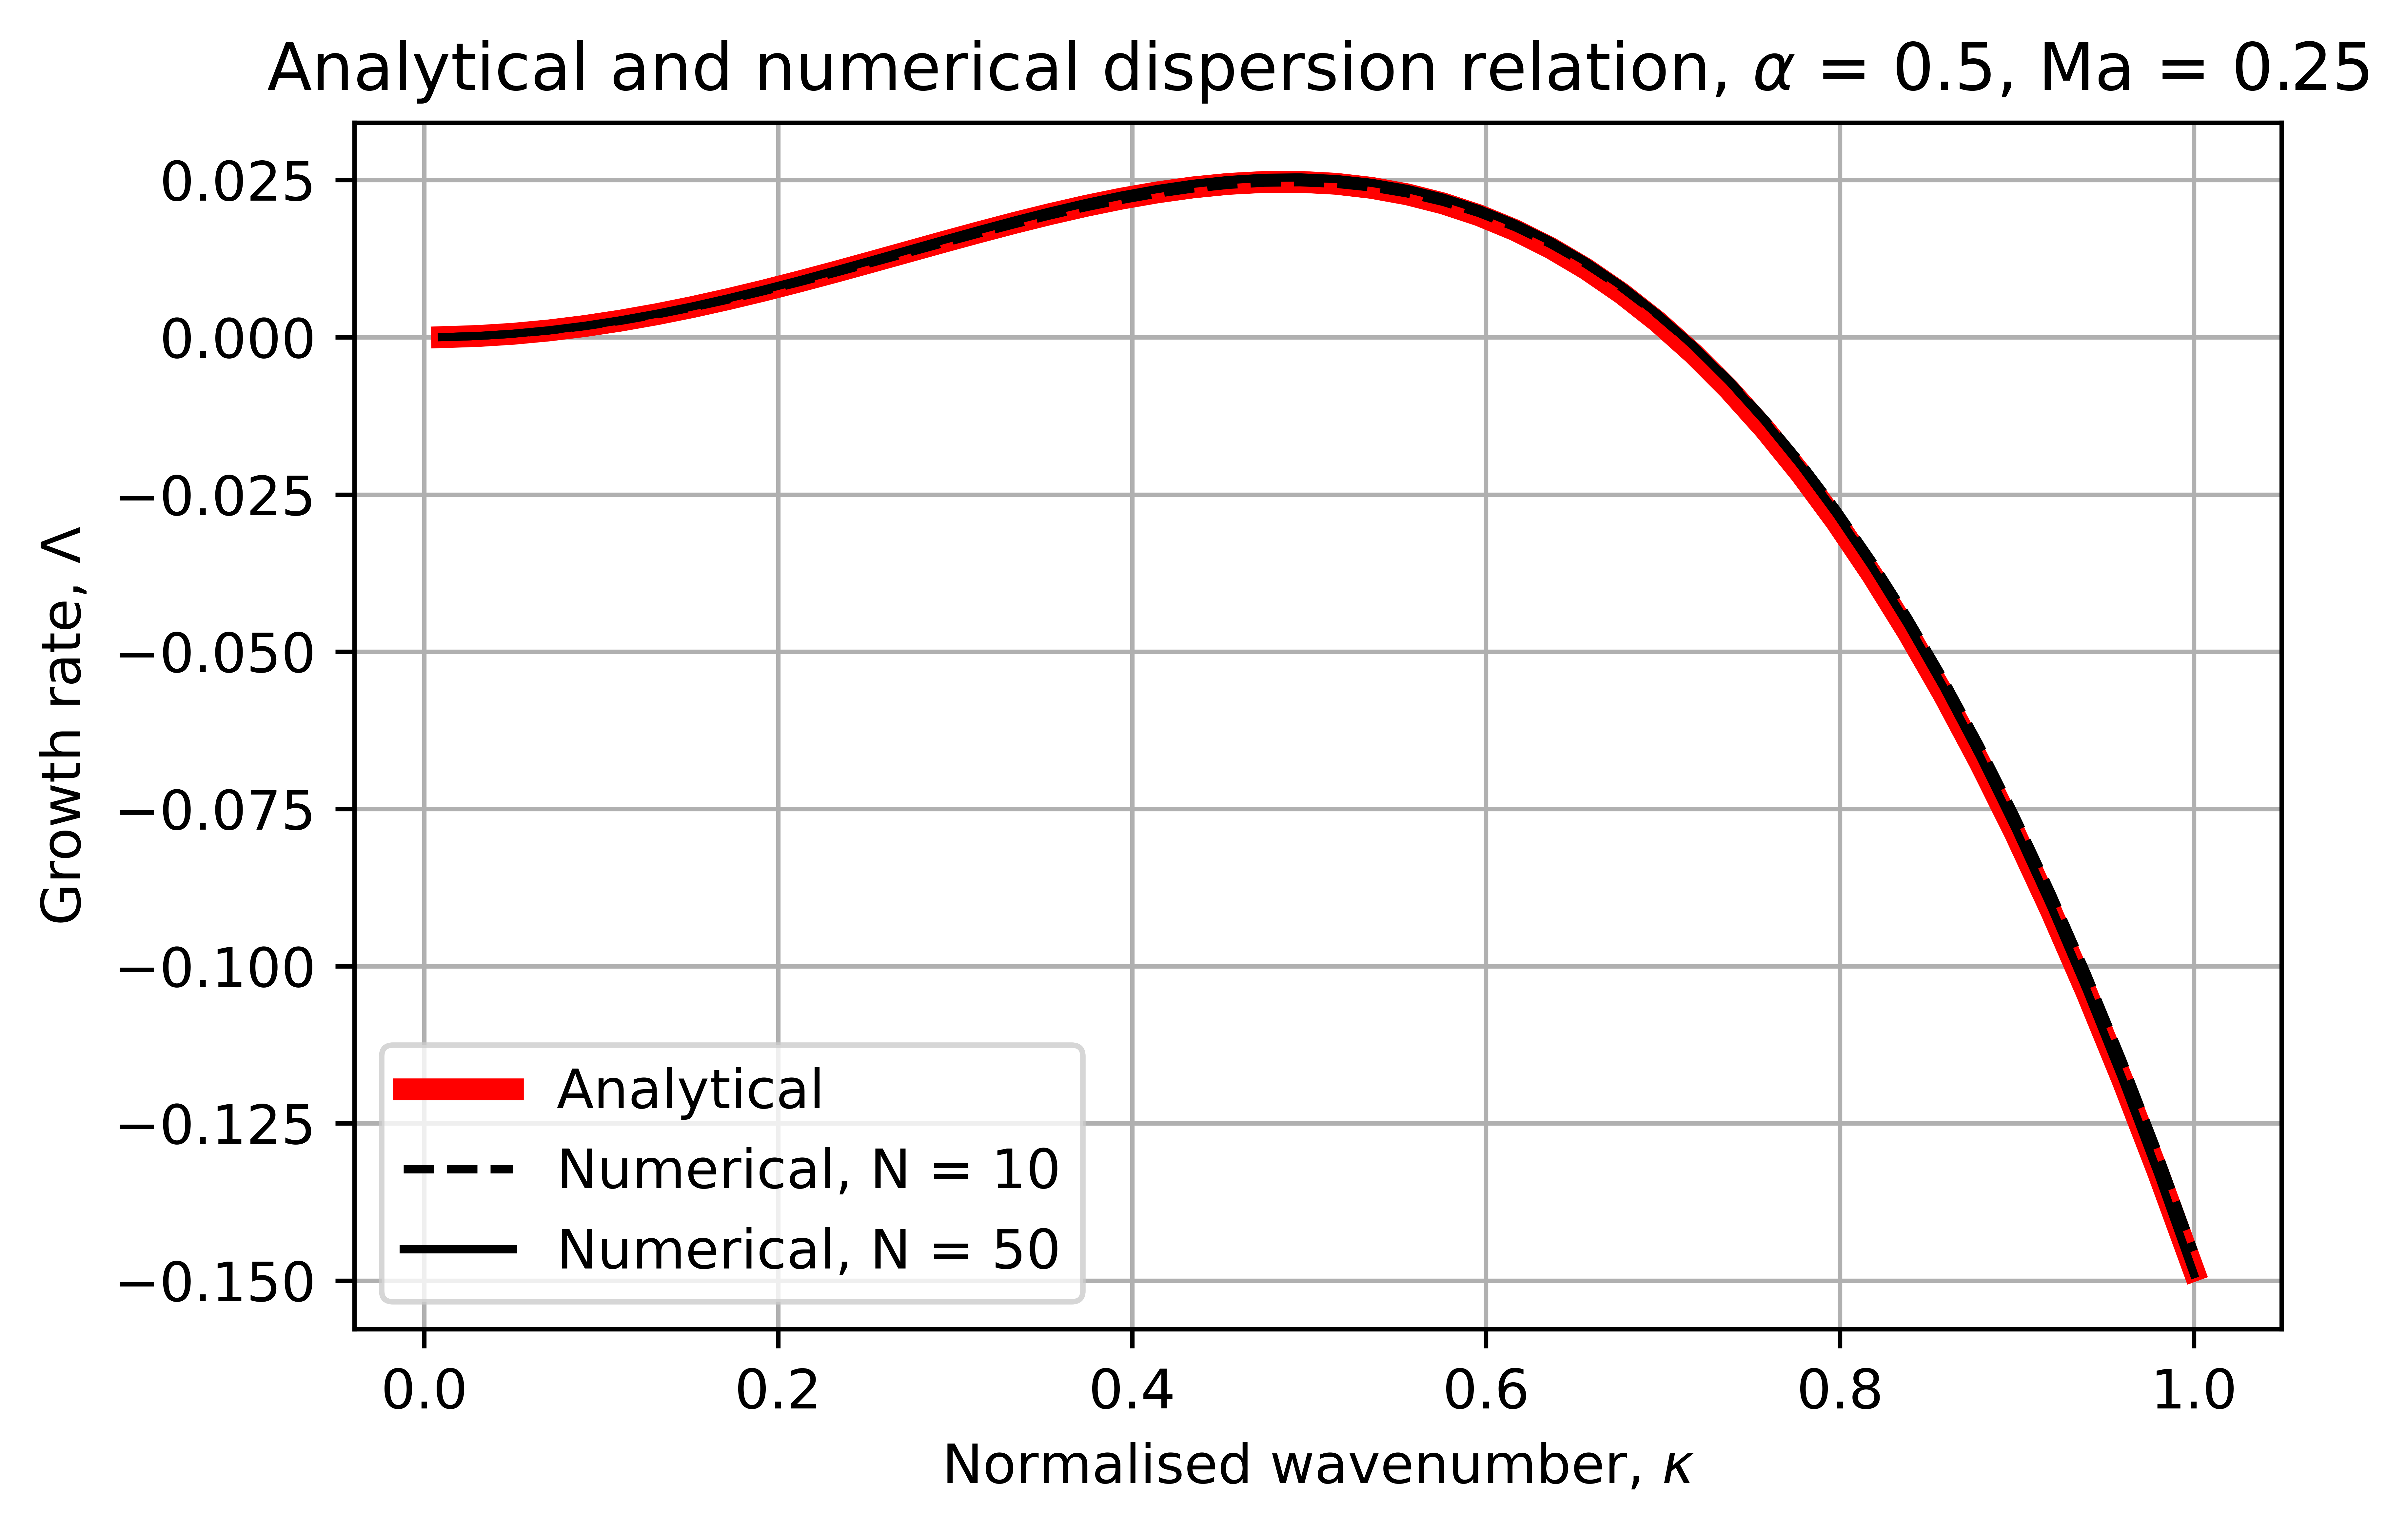

In [203]:
fig, ax = plt.subplots(dpi = 1200)
lambda_vect_N_50 = Lambda_vect0.copy()
plt.plot(kappa_vect,Lambda_vect_anal.real, label ='Analytical', color ='red', linewidth = 4)
plt.plot(kappa_vect, lambda_vect_N_10.real, '--',label = 'Numerical, N = 10', color = 'black')
plt.plot(kappa_vect, lambda_vect_N_50.real, label = 'Numerical, N = 50', color = 'black')
plt.grid()
plt.legend()
plt.xlabel(r'Normalised wavenumber, $\kappa$')
plt.ylabel(r'Growth rate, $\Lambda$')
plt.title(fr'Analytical and numerical dispersion relation, $\alpha$ = {alpha_}, Ma = {Ma}')
plt.tight_layout()
plt.savefig(f'figures/alpha_{alpha_}_Ma_{Ma}.pdf')
plt.show()